In [1]:
# Required imports
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Fetch the dataset
online_retail = fetch_ucirepo(id=352)

# Create full dataframe
X = pd.concat([online_retail.data.ids, online_retail.data.features], axis=1)
X.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
# Define product categories based on keywords in descriptions
def categorize_product(description):
    description = str(description).lower()
    
    if pd.isna(description) or description == 'nan':
        return 'Unknown'
    
    # Define categories and their keywords
    categories = {
        'Kitchen & Dining': ['kitchen', 'dining', 'plate', 'cup', 'mug', 'bowl', 'spoon', 'fork', 'knife', 'dish', 
                             'tea', 'coffee', 'baking', 'cook', 'chef', 'oven', 'lunch box', 'cake'],
        'Home Decor': ['decor', 'sign', 'frame', 'candle', 'holder', 'vase', 'ornament', 'figurine', 'statue', 
                       'hanging', 'wall', 'picture', 'art', 'clock', 'lantern', 'light'],
        'Garden': ['garden', 'plant', 'flower', 'outdoor', 'bird', 'water', 'grow'],
        'Storage': ['storage', 'box', 'basket', 'bin', 'container', 'jar', 'bag', 'hanger', 'hook'],
        'Seasonal & Gift': ['christmas', 'easter', 'halloween', 'holiday', 'gift', 'card', 'wrap', 'party', 'birthday',
                           'celebration', 'bunting', 'flag'],
        'Toys & Children': ['toy', 'game', 'play', 'child', 'kid', 'baby', 'doll', 'teddy', 'spaceboy', 'fairy'],
        'Fashion & Accessories': ['fashion', 'accessory', 'jewelry', 'necklace', 'bracelet', 'earring', 'hat', 
                                 'scarf', 'bag', 'purse', 'wallet', 'umbrella'],
        'Bath & Beauty': ['bath', 'beauty', 'soap', 'lotion', 'cosmetic', 'towel', 'shower']
    }
    
    # Check each category's keywords
    for category, keywords in categories.items():
        if any(keyword in description for keyword in keywords):
            return category
    
    # Default category if no keywords match
    return 'Miscellaneous'

# Apply categorization to create a new column
X['ProductCategory'] = X['Description'].apply(categorize_product)

# Display category distribution
category_counts = X['ProductCategory'].value_counts()
print(category_counts)

ProductCategory
Home Decor               153850
Miscellaneous            134763
Kitchen & Dining          88677
Storage                   75200
Seasonal & Gift           42637
Garden                    22640
Toys & Children           15915
Fashion & Accessories      5278
Bath & Beauty              1495
Unknown                    1454
Name: count, dtype: int64


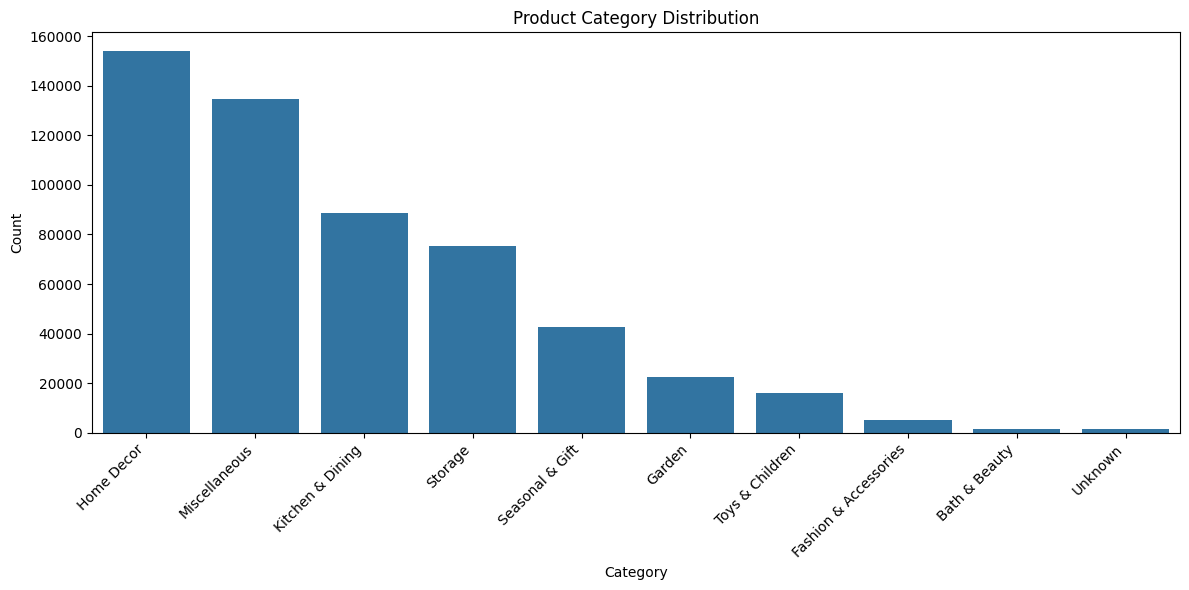

In [3]:
# Visualize category distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Product Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [4]:
# Feature engineering for classification
# We'll use various features from the dataset to predict product category

# Convert InvoiceDate to datetime and extract useful features
X['InvoiceDate'] = pd.to_datetime(X['InvoiceDate'])
X['DayOfWeek'] = X['InvoiceDate'].dt.dayofweek
X['Month'] = X['InvoiceDate'].dt.month
X['Hour'] = X['InvoiceDate'].dt.hour

# Calculate a price per unit category average as a feature
category_price_avg = X.groupby('ProductCategory')['UnitPrice'].mean()
X['CategoryPriceRatio'] = X['UnitPrice'] / X['ProductCategory'].map(category_price_avg)

# Create features from StockCode (first character might indicate product line)
X['StockCodePrefix'] = X['StockCode'].astype(str).str[0]

# Select features for classification
features = ['Quantity', 'UnitPrice', 'DayOfWeek', 'Month', 'Hour', 'CategoryPriceRatio', 'StockCodePrefix', 'Country']
target = 'ProductCategory'

# Define preprocessing for numeric and categorical features
numeric_features = ['Quantity', 'UnitPrice', 'DayOfWeek', 'Month', 'Hour', 'CategoryPriceRatio']
categorical_features = ['StockCodePrefix', 'Country']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X[features], X[target], test_size=0.3, random_state=42)

# Define classifiers to compare
classifiers = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,  
        max_depth=10,      
        min_samples_split=10,
        random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=3,       
        random_state=42)
}

# Results dictionary
results = {}

# Train and evaluate each classifier
for name, classifier in classifiers.items():
    # Create a pipeline with preprocessing and the classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }
    
    print(f"\n--- {name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


--- Random Forest Results ---
Accuracy: 0.5280
F1 Score: 0.4406

Classification Report:
                       precision    recall  f1-score   support

        Bath & Beauty       0.00      0.00      0.00       471
Fashion & Accessories       0.67      0.38      0.49      1548
               Garden       0.00      0.00      0.00      6919
           Home Decor       0.40      0.97      0.56     46187
     Kitchen & Dining       0.81      0.10      0.18     26436
        Miscellaneous       0.82      0.84      0.83     40667
      Seasonal & Gift       0.99      0.22      0.35     12767
              Storage       0.93      0.04      0.07     22364
      Toys & Children       0.00      0.00      0.00      4798
              Unknown       1.00      0.39      0.56       416

             accuracy                           0.53    162573
            macro avg       0.56      0.29      0.30    162573
         weighted avg       0.66      0.53      0.44    162573


--- Gradient Boosting Res

<Figure size 1000x600 with 0 Axes>

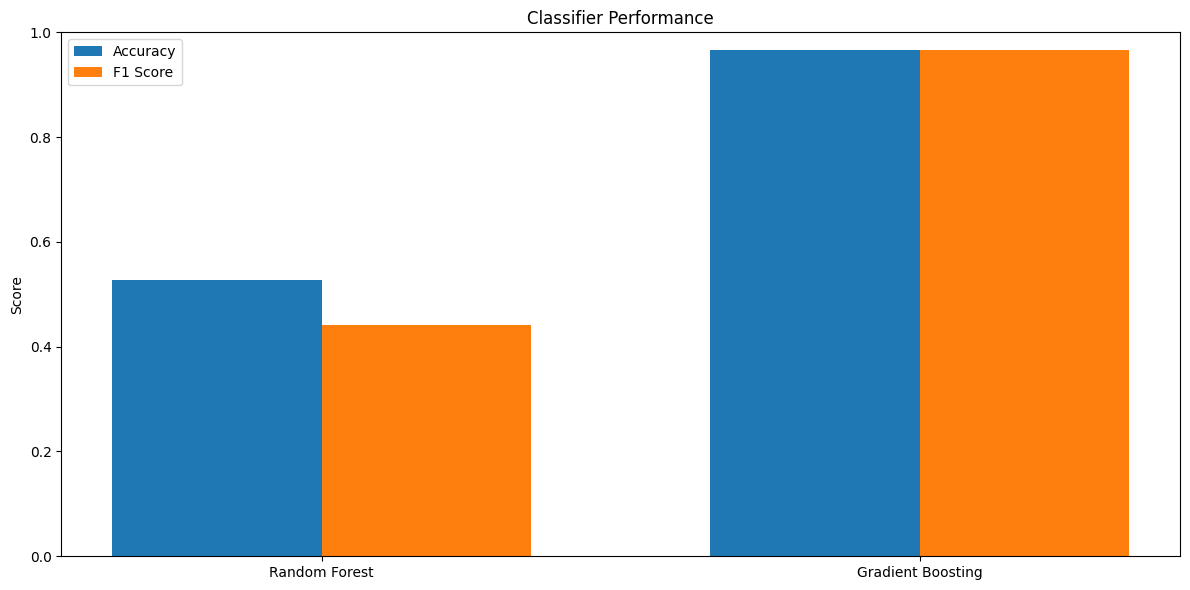

In [8]:
# Visualize results
plt.figure(figsize=(10, 6))
accuracies = [results[name]['accuracy'] for name in classifiers.keys()]
f1_scores = [results[name]['f1_score'] for name in classifiers.keys()]

x = np.arange(len(classifiers))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, accuracies, width, label='Accuracy')
ax.bar(x + width/2, f1_scores, width, label='F1 Score')

ax.set_ylabel('Score')
ax.set_title('Classifier Performance')
ax.set_xticks(x)
ax.set_xticklabels(classifiers.keys())
ax.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X[features], X[target], test_size=0.3, random_state=42)

# Define a neural network classifier with three hidden layers
neural_net = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),  # Three hidden layers with decreasing neurons
    activation='relu',                 # ReLU activation function
    solver='adam',                     # Adam optimizer
    alpha=0.0001,                      # L2 regularization term
    batch_size=256,                    # Mini-batch size
    learning_rate='adaptive',          # Adaptive learning rate
    max_iter=200,                      # Maximum number of iterations
    early_stopping=True,               # Use early stopping to prevent overfitting
    validation_fraction=0.1,           # Fraction of training data for validation
    n_iter_no_change=10,               # Number of iterations with no improvement to wait before early stopping
    random_state=42
)

# Create a pipeline with preprocessing and the neural network
nn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', neural_net)
])

# Fit the model
print("Training Neural Network...")
nn_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = nn_pipeline.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Store results
results['Neural Network'] = {
    'accuracy': accuracy,
    'f1_score': f1,
    'confusion_matrix': confusion_matrix(y_test, y_pred),
    'classification_report': classification_report(y_test, y_pred, output_dict=True)
}

print(f"\n--- Neural Network Results ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compare with previous classifiers
print("\n--- Comparison of All Models ---")
for model_name, model_results in results.items():
    print(f"{model_name}: Accuracy = {model_results['accuracy']:.4f}, F1 Score = {model_results['f1_score']:.4f}")

Training Neural Network...

--- Neural Network Results ---
Accuracy: 0.9193
F1 Score: 0.9179

Classification Report:
                       precision    recall  f1-score   support

        Bath & Beauty       1.00      0.00      0.01       471
Fashion & Accessories       0.90      0.81      0.85      1548
               Garden       0.96      0.97      0.97      6919
           Home Decor       0.98      0.99      0.98     46187
     Kitchen & Dining       0.80      0.78      0.79     26436
        Miscellaneous       0.99      1.00      1.00     40667
      Seasonal & Gift       0.99      0.99      0.99     12767
              Storage       0.74      0.78      0.76     22364
      Toys & Children       0.97      0.81      0.88      4798
              Unknown       1.00      1.00      1.00       416

             accuracy                           0.92    162573
            macro avg       0.93      0.81      0.82    162573
         weighted avg       0.92      0.92      0.92    162573